In [1]:
import math
import matplotlib.pyplot as plt
import keras
import tensorflow
import numpy as np

from keras.models import Model
from keras import optimizers
from keras.callbacks import TensorBoard
from keras.datasets import mnist
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D

Using TensorFlow backend.


In [2]:
def model_keras(X_train, Y_train, X_test, Y_test):
    input_img = Input(shape=(28, 28, 1))

    x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    enc = MaxPooling2D((2, 2), padding = 'same')(x)
        
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(enc)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(8, (3, 3), activation='relu', padding = 'same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(16, (3, 3), activation='relu')(x)
    x = UpSampling2D((2, 2))(x)
    dec = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    
    autoenc = Model(input_img, dec)
    autoenc.compile(optimizer='adadelta', loss='binary_crossentropy')
    
    
    autoenc.fit(X_train, Y_train, epochs=2, batch_size=128, shuffle=True, validation_data=(X_test, Y_test),
                    callbacks=[TensorBoard(log_dir='conv_autoenc')], verbose=2)
    
    dec_images = autoenc.predict(X_test)
    
    n = 10
    plt.figure(figsize=(10, 4), dpi=100)
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(X_test[i].reshape(28, 28))
        plt.gray()
        ax.set_axis_off()

        # display reconstruction
        ax = plt.subplot(2, n, i + n + 1)
        plt.imshow(dec_images[i].reshape(28, 28))
        plt.gray()
        ax.set_axis_off()

    plt.show()
    
    return autoenc

In [3]:

(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.


X_train = np.reshape(X_train, (len(X_train), 28, 28, 1))    
X_test = np.reshape(X_test, (len(X_test), 28, 28, 1))

11493376/11490434 [==============================] - 1s 0us/step


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 60000 samples, validate on 10000 samples
Epoch 1/2
 - 4s - loss: 0.2069 - val_loss: 0.1625
Epoch 2/2
 - 3s - loss: 0.1545 - val_loss: 0.1486


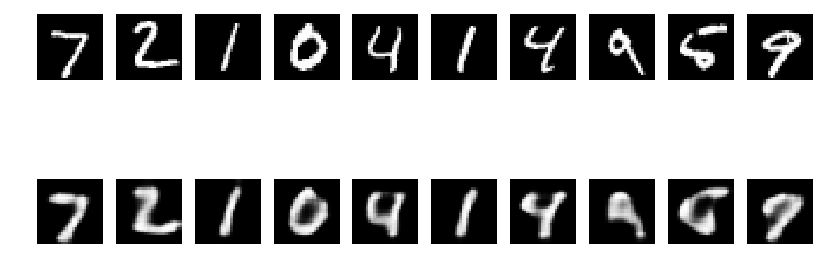

In [4]:
auto_enc = model_keras(X_train, X_train, X_test, X_test)

In [5]:
def convolve(x, y, img_channel, img_filter): 
    sum = 0
    fil_r = img_filter.shape[0]
    fil_col = img_filter.shape[1]
    for i in range(fil_r):
        for j in range(fil_col):
            sum += img_filter[i][j] * img_channel[x + i][y + j]
    return sum

In [6]:
def m_Conv2D(img, img_filters, padding = "not same"):
    layer_shape = img_filters[0].shape
    print(layer_shape)
    
    img_rows = img.shape[0]
    img_col = img.shape[1]
        
    in_chan = layer_shape[2]
    out_chan = layer_shape[3]
    
    rows_cut = int((layer_shape[0] - 1) / 2)
    col_cut = int((layer_shape[1] - 1) / 2)
    
    output = []
        
    new_img = []
            
    if padding == "same":
        new_img = np.empty((img_rows + 2 * rows_cut, img_col + 2 * col_cut, in_chan))
        for input_channel in range(in_chan):
            new_img[:, :, input_channel] = np.pad(img[:, :, input_channel], ((rows_cut, rows_cut),(col_cut, col_cut)), 'constant')
        output = np.zeros((img_rows, img_col, out_chan))
    else:
        new_img = np.zeros((img_rows, img_col, in_chan)) 
        output = np.zeros((img_rows - 2 * rows_cut, img_col - 2 * col_cut, out_chan))
        new_img = img
        
    new_img_rows = new_img.shape[0]
    new_img_col = new_img.shape[1]
        
    for out_chan in range(out_chan):
        for input_channel in range(in_chan):
            img_channel = new_img[:, :, input_channel]
            img_filter = img_filters[0][:, : , input_channel, out_chan]
            
            for x in range(new_img_rows):
                for y in range(new_img_col):
                    if x + img_filter.shape[0] <= new_img_rows and y + img_filter.shape[1] <= new_img_col:
                        output[x, y, out_chan] += convolve(x, y, img_channel, img_filter)
    return output

In [7]:
image = X_test[1]

z = m_Conv2D(image, auto_enc.get_layer(index = 1).get_weights(), "same")

print(z.shape)
    

(3, 3, 1, 16)
(28, 28, 16)


In [8]:
def m_MaxPooling2D(img, pool_size):
    img_rows = img.shape[0]
    img_columns = img.shape[1]
    pool_rows = pool_size[0]
    pool_columns = pool_size[1]
    out_chan = img.shape[2]
    
    output = np.empty((int(math.ceil(img_rows / pool_rows)), int(math.ceil(img_columns / pool_columns)), out_chan))
    
    for out_chan in range(out_chan):
        for x in range(0, img_rows, pool_rows):
            for y in range(0, img_columns, pool_columns):
                max_num = 0
                for i in range(pool_rows):
                    for j in range(pool_columns):
                        if x + i < img_rows and y + j < img_columns:
                                max_num = max(max_num, img[x + i][y + j][out_chan])
                output[int(x / pool_rows)][int(y / pool_columns)][out_chan] = max_num
    return output

In [9]:
def m_UpSampling2D(img, upsample_size):
    img_rows = img.shape[0]
    img_columns = img.shape[1]
    upsample_rows = upsample_size[0]
    upsample_columns = upsample_size[1]
    out_chan = img.shape[2]
    
    output = np.empty((img_rows * upsample_rows, img_columns * upsample_columns, out_chan))
    
    for out_chan in range(out_chan):
        for x in range(img_rows):
            for y in range(img_columns):
                for i in range(upsample_rows):
                    for j in range(upsample_columns):
                        output[x * upsample_rows + i][y * upsample_columns + j][out_chan] = img[x][y][out_chan]
    return output

In [10]:
def relu(x):
    return np.maximum(0,x)

In [11]:
def m_model(x_test, index, activation):
    image = x_test[index]
    print(image.shape)
    temp = m_Conv2D(image, auto_enc.get_layer(index = 1).get_weights(), "same")
    print(temp.shape)

    temp = relu(temp)
#     print(temp.shape)

    temp = m_MaxPooling2D(temp, (2, 2))
    print(temp.shape)
    temp = m_Conv2D(temp, auto_enc.get_layer(index = 3).get_weights(), "same")
    print(temp.shape)
    temp = relu(temp)
#     print(temp.shape)
    temp = m_MaxPooling2D(temp, (2, 2))
    print(temp.shape)
    temp = m_Conv2D(temp, auto_enc.get_layer(index = 5).get_weights(), "same")
    print(temp.shape)
    temp = relu(temp)
#     print(temp.shape)
    temp = m_MaxPooling2D(temp, (2, 2))
    print(temp.shape)
    
#     print("Decoding")
    temp = m_Conv2D(temp, auto_enc.get_layer(index = 7).get_weights(), "same")
    print(temp.shape)
    temp = relu(temp)
#     print(temp.shape)
    temp = m_UpSampling2D(temp, (2, 2))
    print(temp.shape)
    temp = m_Conv2D(temp, auto_enc.get_layer(index = 9).get_weights(), "same")
    print(temp.shape)
    temp = relu(temp)
#     print(temp.shape)
    temp = m_UpSampling2D(temp, (2, 2))
    print(temp.shape)
    temp = m_Conv2D(temp, auto_enc.get_layer(index = 11).get_weights())
    print(temp.shape)
    temp = relu(temp)
#     print(temp.shape)
    temp = m_UpSampling2D(temp, (2, 2))
    print(temp.shape)
    temp = m_Conv2D(temp, auto_enc.get_layer(index = 13).get_weights(), "same")
#     print(temp.shape)
    
    temp = activation(temp)

    return temp

In [12]:
dec_imgs = []

for index in range(10):
    dec_imgs.append(m_model(X_test, index, relu))

(28, 28, 1)
(3, 3, 1, 16)
(28, 28, 16)
(14, 14, 16)
(3, 3, 16, 8)
(14, 14, 8)
(7, 7, 8)
(3, 3, 8, 8)
(7, 7, 8)
(4, 4, 8)
(3, 3, 8, 8)
(4, 4, 8)
(8, 8, 8)
(3, 3, 8, 8)
(8, 8, 8)
(16, 16, 8)
(3, 3, 8, 16)
(14, 14, 16)
(28, 28, 16)
(3, 3, 16, 1)
(28, 28, 1)
(3, 3, 1, 16)
(28, 28, 16)
(14, 14, 16)
(3, 3, 16, 8)
(14, 14, 8)
(7, 7, 8)
(3, 3, 8, 8)
(7, 7, 8)
(4, 4, 8)
(3, 3, 8, 8)
(4, 4, 8)
(8, 8, 8)
(3, 3, 8, 8)
(8, 8, 8)
(16, 16, 8)
(3, 3, 8, 16)
(14, 14, 16)
(28, 28, 16)
(3, 3, 16, 1)
(28, 28, 1)
(3, 3, 1, 16)
(28, 28, 16)
(14, 14, 16)
(3, 3, 16, 8)
(14, 14, 8)
(7, 7, 8)
(3, 3, 8, 8)
(7, 7, 8)
(4, 4, 8)
(3, 3, 8, 8)
(4, 4, 8)
(8, 8, 8)
(3, 3, 8, 8)
(8, 8, 8)
(16, 16, 8)
(3, 3, 8, 16)
(14, 14, 16)
(28, 28, 16)
(3, 3, 16, 1)
(28, 28, 1)
(3, 3, 1, 16)
(28, 28, 16)
(14, 14, 16)
(3, 3, 16, 8)
(14, 14, 8)
(7, 7, 8)
(3, 3, 8, 8)
(7, 7, 8)
(4, 4, 8)
(3, 3, 8, 8)
(4, 4, 8)
(8, 8, 8)
(3, 3, 8, 8)
(8, 8, 8)
(16, 16, 8)
(3, 3, 8, 16)
(14, 14, 16)
(28, 28, 16)
(3, 3, 16, 1)
(28, 28, 1)
(3, 3, 1, 16)
(2

In [13]:
print(len(dec_imgs))

10


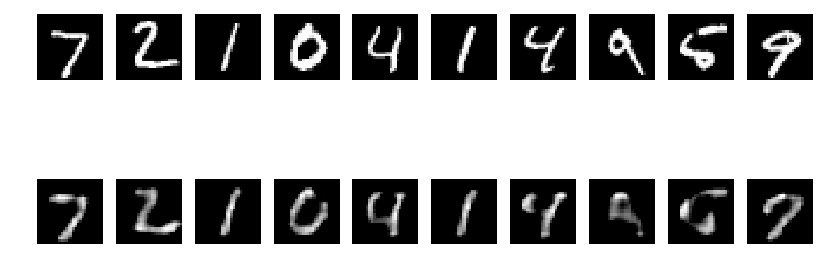

In [14]:
n = 10
plt.figure(figsize=(10, 4), dpi=100)
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    ax.set_axis_off()

    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(dec_imgs[i].reshape(28, 28))
    plt.gray()
    ax.set_axis_off()

plt.show()